[View in Colaboratory](https://colab.research.google.com/github/keisuke-umezawa/chainer-colab-notebook/blob/feature/add-cupy/Hands-on(en)/cupy/prml/ch01_Introduction_ipynb.ipynb)

# 1. Introduction

In [0]:
# Install CuPy and import as np !

!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
  
import cupy as np
import numpy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcusparse8.0 is already the newest version (8.0.61-1).
libnvrtc8.0 is already the newest version (8.0.61-1).
libnvtoolsext1 is already the newest version (8.0.61-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [0]:
class Regressor(object):
    """
    Base class for regressors
    """

    def fit(self, X, t, **kwargs):
        """
        estimates parameters given training dataset
        Parameters
        ----------
        X : (sample_size, n_features) np.ndarray
            training data input
        t : (sample_size,) np.ndarray
            training data target
        """
        self._check_input(X)
        self._check_target(t)
        if hasattr(self, "_fit"):
            self._fit(X, t, **kwargs)
        else:
            raise NotImplementedError

    def predict(self, X, **kwargs):
        """
        predict outputs of the model
        Parameters
        ----------
        X : (sample_size, n_features) np.ndarray
            samples to predict their output
        Returns
        -------
        y : (sample_size,) np.ndarray
            prediction of each sample
        """
        self._check_input(X)
        if hasattr(self, "_predict"):
            return self._predict(X, **kwargs)
        else:
            raise NotImplementedError

    def _check_input(self, X):
        if not isinstance(X, np.ndarray):
            raise ValueError("X(input) is not np.ndarray")
        if X.ndim != 2:
            raise ValueError("X(input) is not two dimensional array")
        if hasattr(self, "n_features") and self.n_features != np.size(X, 1):
            raise ValueError(
                "mismatch in dimension 1 of X(input) "
                "(size {} is different from {})"
                .format(np.size(X, 1), self.n_features)
            )

    def _check_target(self, t):
        if not isinstance(t, np.ndarray):
            raise ValueError("t(target) must be np.ndarray")
        if t.ndim != 1:
            raise ValueError("t(target) must be one dimenional array")

In [0]:
class LinearRegressor(Regressor):
    """
    Linear regression model
    y = X @ w
    t ~ N(t|X @ w, var)
    """

    def _fit(self, X, t):
        self.w = np.linalg.pinv(X) @ t
        self.var = np.mean(np.square(X @ self.w - t))

    def _predict(self, X, return_std=False):
        y = X @ self.w
        if return_std:
            y_std = np.sqrt(self.var) + np.zeros_like(y)
            return y, y_std
        return y

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

## 1.1. Example: Polynomial Curve Fitting

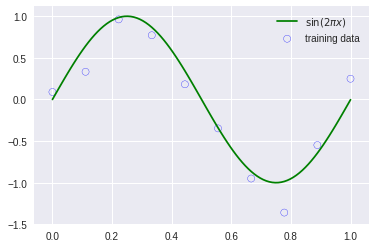

In [0]:
def create_toy_data(func, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def func(x):
    return np.sin(2 * 3.14 * x)  # 3.14 should be np.pi

x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

plt.scatter(x_train.get(), y_train.get(), facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test.get(), y_test.get(), c="g", label="$\sin(2\pi x)$")
plt.legend()
plt.show()

In [0]:
import itertools
import functools


class PolynomialFeatures(object):
    """
    polynomial features
    transforms input array with polynomial features
    Example
    =======
    x =
    [[a, b],
    [c, d]]
    y = PolynomialFeatures(degree=2).transform(x)
    y =
    [[1, a, b, a^2, a * b, b^2],
    [1, c, d, c^2, c * d, d^2]]
    """

    def __init__(self, degree=2):
        """
        construct polynomial features
        Parameters
        ----------
        degree : int
            degree of polynomial
        """
        assert isinstance(degree, int)
        self.degree = degree

    def transform(self, x):
        """
        transforms input array with polynomial features
        Parameters
        ----------
        x : (sample_size, n) ndarray
            input array
        Returns
        -------
        output : (sample_size, 1 + nC1 + ... + nCd) ndarray
            polynomial features
        """
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose().get()  # https://github.com/cupy/cupy/issues/1084
        features = [numpy.ones(len(x))]    # https://github.com/cupy/cupy/issues/1084
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        features = numpy.array(features)  # https://github.com/cupy/cupy/issues/1084
        return np.asarray(features).transpose()

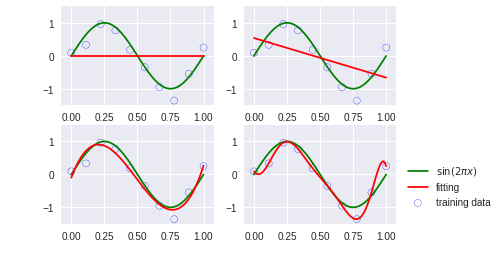

In [0]:
for i, degree in enumerate([0, 1, 3, 9]):
    plt.subplot(2, 2, i + 1)
    feature = PolynomialFeatures(degree)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegressor()
    model.fit(X_train, y_train)
    y = model.predict(X_test)

    plt.scatter(x_train.get(), y_train.get(), facecolor="none", edgecolor="b", s=50, label="training data")
    plt.plot(x_test.get(), y_test.get(), c="g", label="$\sin(2\pi x)$")
    plt.plot(x_test.get(), y.get(), c="r", label="fitting")
    plt.ylim(-1.5, 1.5)
    plt.annotate("M={}".format(degree), xy=(-0.15, 1))
plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
plt.show()

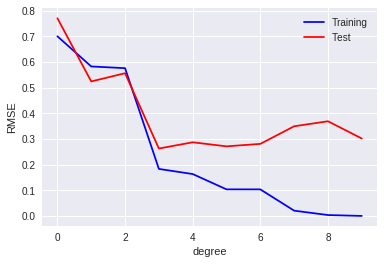

In [0]:
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

training_errors = []
test_errors = []

for i in range(10):
    feature = PolynomialFeatures(i)
    X_train = feature.transform(x_train)
    X_test = feature.transform(x_test)

    model = LinearRegressor()
    model.fit(X_train, y_train)
    y = model.predict(X_test)
    training_errors.append(rmse(model.predict(X_train), y_train))
    test_errors.append(rmse(model.predict(X_test), y_test + np.random.normal(scale=0.25, size=len(y_test))))

plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("RMSE")
plt.show()

#### Regularization

In [0]:
class RidgeRegressor(Regressor):
    """
    Ridge regression model
    w* = argmin |t - X @ w| + a * |w|_2^2
    """

    def __init__(self, alpha=1.):
        self.alpha = alpha

    def _fit(self, X, t):
        eye = np.eye(np.size(X, 1))
        self.w = np.linalg.solve(self.alpha * eye + X.T @ X, X.T @ t)

    def _predict(self, X):
        y = X @ self.w
        return y

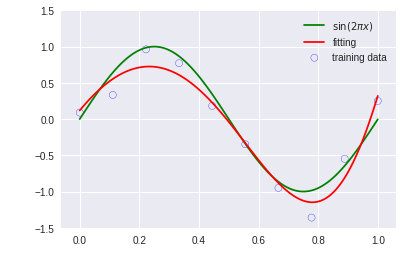

In [0]:
feature = PolynomialFeatures(9)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = RidgeRegressor(alpha=1e-3)
model.fit(X_train, y_train)
y = model.predict(X_test)

y = model.predict(X_test)
plt.scatter(x_train.get(), y_train.get(), facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test.get(), y_test.get(), c="g", label="$\sin(2\pi x)$")
plt.plot(x_test.get(), y.get(), c="r", label="fitting")
plt.ylim(-1.5, 1.5)
plt.legend()
plt.annotate("M=9", xy=(-0.15, 1))
plt.show()

### 1.2.6 Bayesian curve fitting

In [0]:
class BayesianRegressor(Regressor):
    """
    Bayesian regression model
    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha=1., beta=1.):
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None
        self.w_precision = None

    def _fit(self, X, t):
        if self.w_mean is not None:
            mean_prev = self.w_mean
        else:
            mean_prev = np.zeros(np.size(X, 1))
        if self.w_precision is not None:
            precision_prev = self.w_precision
        else:
            precision_prev = self.alpha * np.eye(np.size(X, 1))
        w_precision = precision_prev + self.beta * X.T @ X
        w_mean = np.linalg.solve(
            w_precision,
            precision_prev @ mean_prev + self.beta * X.T @ t
        )
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(self.w_precision)

    def _predict(self, X, return_std=False, sample_size=None):
        if isinstance(sample_size, int):
            w_sample = np.random.multivariate_normal(
                self.w_mean, self.w_cov, size=sample_size
            )
            y = X @ w_sample.T
            return y
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
            y_std = np.sqrt(y_var)
            return y, y_std
        return y

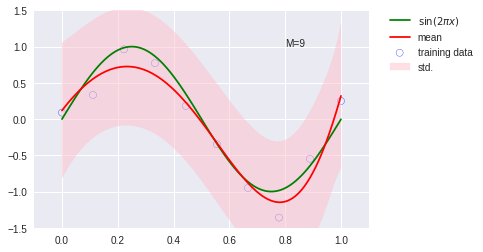

In [0]:
model = BayesianRegressor(alpha=2e-3, beta=2)
model.fit(X_train, y_train)

y, y_err = model.predict(X_test, return_std=True)
plt.scatter(x_train.get(), y_train.get(), facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test.get(), y_test.get(), c="g", label="$\sin(2\pi x)$")
plt.plot(x_test.get(), y.get(), c="r", label="mean")
plt.fill_between(x_test.get(), (y - y_err).get(), (y + y_err).get(), color="pink", label="std.", alpha=0.5)
plt.xlim(-0.1, 1.1)
plt.ylim(-1.5, 1.5)
plt.annotate("M=9", xy=(0.8, 1))
plt.legend(bbox_to_anchor=(1.05, 1.), loc=2, borderaxespad=0.)
plt.show()